In [1]:
# Importamos las librerias que vamos a utilizar
import matplotlib.pyplot as plt
import pandas as pd
import re
#from funciones import *

In [2]:
# Creamos una lista de los campos de búsqueda
campos_busqueda = ['kw', 'au', 'mc-itype', 'ti', 'an', 'itype', 'su', 'BC', 'bc', 'callnum', 
    'I-format', 'AU', 'an', 'se', 'In', 'bx', 'se', 'su-to', 'mc-itype,phr', 'l-format', 'Provider']

# Creamos una expresión regular para encontrar los campos
patrones = r'\b(?:' + '|'.join(campos_busqueda) + r')\b'

# Funcion para extraer el campo de cada fila
def extraer_campo(texto):
    """
    Extrae un campo específico de un texto dado utilizando una expresión regular.
    Args:
        texto (str): El texto del cual se desea extraer el campo.
    Returns:
        str or None: El campo extraído si se encuentra una coincidencia, de lo contrario, None.
    """
    match = re.search(patrones, texto)
    return match.group(0) if match else None

In [3]:
# Funcion para extraer la sintaxis de cada fila
def extraer_sintaxis(texto):
    """
    Extrae la sintaxis de cada búsqueda de los usuarios.
    Args:
        texto (str): El texto de la búsqueda.
    Returns:
        str: La sintaxis extraída.
    """
    sintaxis = re.findall(r':\s*([^,]+)', texto)
    return ', '.join(sintaxis)

In [4]:
# Lista de campos que necesitan un número
campos_necesitan_numero = ['an', 'bc', 'callnum']

# Función para verificar si el campo necesita un número y el usuario ingresó un string
def verificar_error_campo(row):
    if len(row['sintaxis']) == 0 or row['sintaxis'] == ' ' or row['sintaxis'] == None:
        return 'usuario no ingresó nada'
    elif row['campo_utilizado'] in campos_necesitan_numero and not row['sintaxis'].isdigit():
        return 'campo incorrecto'
    return ''

In [5]:
# Abrimos el archivo 'Estadisticas consultas catálogo-reportresults.csv' que contiene los datos de la busqueda de los usuarios en el sistema Koha
data_frame = pd.read_csv("d:/Users/Laura/Desktop/Espacio Integrador II/3 - Practica Academica/Practica-Acad-mica/1 - archivos/Estadísticas consultas catálogo-reportresults.csv", sep=';')

### Identificación de las variables más importantes
##### Se identificarán las variables que ayudarán a resolver nuestro problema

In [6]:
# Filtramos el data frame, nos quedaremos con las variables que resolverán nuestro problema
df_filtrado = data_frame[['sessionid', 'query_desc', 'total', 'time', 'categorycode']]

# Mostramos las primeras filas del data frame filtrado
df_filtrado.head()

,sessionid,query_desc,total,time,categorycode
0,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: bronzino",16,2018-10-17 15:27:49,DOCENTE
1,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: bronzino",16,2018-10-17 15:28:25,DOCENTE
2,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: webster",10,2018-10-17 15:29:51,DOCENTE
3,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: webster",10,2018-10-17 15:30:02,DOCENTE
4,8b973f78de404b6eb6548e4a229cb725,"au,wrdl: webster",10,2018-10-17 15:30:13,DOCENTE


### Etapa de limpieza

In [7]:
# Borramos valores duplicados en el data frame filtrado
df_filtrado.drop_duplicates()

print("Cantidad de filas duplicadas eliminadas:", len(df_filtrado) - len(df_filtrado.drop_duplicates()))

Cantidad de filas duplicadas eliminadas: 65


In [8]:
# Nos fijamos si las columnas tienen algún valor nulo
df_filtrado.info()

# Podemos observar que de las 2535 filas ninguna posee valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sessionid     2535 non-null   object
 1   query_desc    2535 non-null   object
 2   total         2535 non-null   int64 
 3   time          2535 non-null   object
 4   categorycode  2535 non-null   object
dtypes: int64(1), object(4)
memory usage: 99.2+ KB


In [9]:
# Guardamos el DataFrame filtrado en un archivo CSV, para poder trabajar en otras ramas
df_filtrado.to_csv('1 - archivos/df_filtrado.csv', index=False)

### Preparación de los datos para el análisis estadístico

In [10]:
# Buscamos las búsquedas que no tienen un campo ingresado
filas_sin_query = df_filtrado[~ df_filtrado['query_desc'].str.contains(patrones, na=False)]

In [11]:
# Imputamos las filas que no tienen campos ingresados
filas_sin_query.loc[filas_sin_query.index == 750, 'query_desc'] = filas_sin_query.loc[750, 'query_desc'].replace('robot', 'kw: robot')
filas_sin_query.loc[filas_sin_query.index == 752, 'query_desc'] = filas_sin_query.loc[752, 'query_desc'].replace('robot', 'kw: robot')
filas_sin_query.loc[filas_sin_query.index == 754, 'query_desc'] = filas_sin_query.loc[754, 'query_desc'].replace('da vinci', 'kw,wrdl: da vinci')
filas_sin_query.loc[filas_sin_query.index == 756, 'query_desc'] = filas_sin_query.loc[756, 'query_desc'].replace('robotica', 'kw: robotica')

In [12]:
# Actualizamos los valores de los campos de busqueda en el data frame principal
df_filtrado.update(filas_sin_query)

In [13]:
# Aplicar la función para crear una nueva columna 'campos_utilzado'
df_filtrado.loc[:, 'campo_utilizado'] = df_filtrado['query_desc'].apply(extraer_campo)

C:\Users\Laura\AppData\Local\Temp\ipykernel_9880\1394677314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.loc[:, 'campo_utilizado'] = df_filtrado['query_desc'].apply(extraer_campo)


##### Pero como no se guardan todos los campos que utilizo el usuario, tendremos que realizar otra imputacion para estos casos


In [14]:
# Buscamos las filas que tienen más de un : en la búsqueda. Esto nos indica que el usuario ingresó más de un campo de búsqueda
df_filtrado['contador'] = df_filtrado['query_desc'].str.count(':')
# Filtramos las filas que tienen más de un : en la búsqueda
dos_puntos = df_filtrado[df_filtrado['contador'] > 1]

# Borramos la columna 'contador' ya que por ahora no es necesaria
df_filtrado.drop('contador', axis=1, inplace=True)

In [15]:
# Imputación de los campos utilizados por los usuarios para hacer la busqueda
df_filtrado.loc[5, 'campo_utilizado'] = (df_filtrado.loc[5, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[6, 'campo_utilizado'] = (df_filtrado.loc[6, 'campo_utilizado'] + ', su-to' + ', su-to')
df_filtrado.loc[7, 'campo_utilizado'] = (df_filtrado.loc[7, 'campo_utilizado'] + ', su-to' + ', su-to' + ', su-to')
df_filtrado.loc[8, 'campo_utilizado'] = (df_filtrado.loc[8, 'campo_utilizado'] + ', su-to' + ', su-to')
df_filtrado.loc[9, 'campo_utilizado'] = (df_filtrado.loc[9, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[10, 'campo_utilizado'] = (df_filtrado.loc[10, 'campo_utilizado'] + ', su-to' + ', su-to')
df_filtrado.loc[11, 'campo_utilizado'] = (df_filtrado.loc[11, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[29, 'campo_utilizado'] = (df_filtrado.loc[29, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[33, 'campo_utilizado'] = (df_filtrado.loc[33, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[35, 'campo_utilizado'] = (df_filtrado.loc[35, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[48, 'campo_utilizado'] = (df_filtrado.loc[48, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[49, 'campo_utilizado'] = (df_filtrado.loc[49, 'campo_utilizado'] + ', mc-itype' + ', mc-itype')
df_filtrado.loc[111, 'campo_utilizado'] = (df_filtrado.loc[111, 'campo_utilizado'] + ', au')
df_filtrado.loc[252, 'campo_utilizado'] = (df_filtrado.loc[252, 'campo_utilizado'] + ', l-format')
df_filtrado.loc[256, 'campo_utilizado'] = (df_filtrado.loc[256, 'campo_utilizado'] + ', l-format')
df_filtrado.loc[277, 'campo_utilizado'] = (df_filtrado.loc[277, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[288, 'campo_utilizado'] = (df_filtrado.loc[288, 'campo_utilizado'] + ', au')
df_filtrado.loc[358, 'campo_utilizado'] = (df_filtrado.loc[358, 'campo_utilizado'] + ', ti'+ ', not au')
df_filtrado.loc[368, 'campo_utilizado'] = (df_filtrado.loc[368, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[374, 'campo_utilizado'] = (df_filtrado.loc[374, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[395, 'campo_utilizado'] = (df_filtrado.loc[395, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[397, 'campo_utilizado'] = (df_filtrado.loc[397, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[429, 'campo_utilizado'] = (df_filtrado.loc[429, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[431, 'campo_utilizado'] = (df_filtrado.loc[431, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[432, 'campo_utilizado'] = (df_filtrado.loc[432, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[444, 'campo_utilizado'] = (df_filtrado.loc[444, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[453, 'campo_utilizado'] = (df_filtrado.loc[453, 'campo_utilizado'] + ', su')
df_filtrado.loc[628, 'campo_utilizado'] = (df_filtrado.loc[628, 'campo_utilizado'] + ', au')
df_filtrado.loc[636, 'campo_utilizado'] = (df_filtrado.loc[636, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[637, 'campo_utilizado'] = (df_filtrado.loc[637, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[649, 'campo_utilizado'] = (df_filtrado.loc[649, 'campo_utilizado'] + ', au')
df_filtrado.loc[746, 'campo_utilizado'] = (df_filtrado.loc[746, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[747, 'campo_utilizado'] = (df_filtrado.loc[747, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[749, 'campo_utilizado'] = (df_filtrado.loc[749, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[768, 'campo_utilizado'] = (df_filtrado.loc[768, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[773, 'campo_utilizado'] = (df_filtrado.loc[773, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[774, 'campo_utilizado'] = (df_filtrado.loc[774, 'campo_utilizado'] + ', se')
df_filtrado.loc[775, 'campo_utilizado'] = (df_filtrado.loc[775, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[776, 'campo_utilizado'] = (df_filtrado.loc[776, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[779, 'campo_utilizado'] = (df_filtrado.loc[779, 'campo_utilizado'] + ', au')
df_filtrado.loc[780, 'campo_utilizado'] = (df_filtrado.loc[780, 'campo_utilizado'] + ', au')
df_filtrado.loc[862, 'campo_utilizado'] = (df_filtrado.loc[862, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[868, 'campo_utilizado'] = (df_filtrado.loc[868, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[869, 'campo_utilizado'] = (df_filtrado.loc[869, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[884, 'campo_utilizado'] = (df_filtrado.loc[884, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[964, 'campo_utilizado'] = (df_filtrado.loc[964, 'campo_utilizado'] + ', au')
df_filtrado.loc[974, 'campo_utilizado'] = (df_filtrado.loc[974, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[975, 'campo_utilizado'] = (df_filtrado.loc[975, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1117, 'campo_utilizado'] = (df_filtrado.loc[1117, 'campo_utilizado'] + ', au')
df_filtrado.loc[1119, 'campo_utilizado'] = (df_filtrado.loc[1119, 'campo_utilizado'] + ', au')
df_filtrado.loc[1131, 'campo_utilizado'] = (df_filtrado.loc[1131, 'campo_utilizado'] + ', au')
df_filtrado.loc[1187, 'campo_utilizado'] = (df_filtrado.loc[1187, 'campo_utilizado'] + ', au')
df_filtrado.loc[1188, 'campo_utilizado'] = (df_filtrado.loc[1188, 'campo_utilizado'] + ', au')
df_filtrado.loc[1189, 'campo_utilizado'] = (df_filtrado.loc[1189, 'campo_utilizado'] + ', au' + ', mc-itype' + ', mc-itype')
df_filtrado.loc[1196, 'campo_utilizado'] = (df_filtrado.loc[1196, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1223, 'campo_utilizado'] = (df_filtrado.loc[1223, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1273, 'campo_utilizado'] = (df_filtrado.loc[1273, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1275, 'campo_utilizado'] = (df_filtrado.loc[1275, 'campo_utilizado'] + ', au')
df_filtrado.loc[1302, 'campo_utilizado'] = (df_filtrado.loc[1302, 'campo_utilizado'] + ', kw' + ', mc-itype')
df_filtrado.loc[1303, 'campo_utilizado'] = (df_filtrado.loc[1303, 'campo_utilizado'] + ', kw' + ', mc-itype')
df_filtrado.loc[1304, 'campo_utilizado'] = (df_filtrado.loc[1304, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1305, 'campo_utilizado'] = (df_filtrado.loc[1305, 'campo_utilizado'] + ', ti')
df_filtrado.loc[1306, 'campo_utilizado'] = (df_filtrado.loc[1306, 'campo_utilizado'] + ', ti' + ', mc-itype' + ', mc-itype')
df_filtrado.loc[1307, 'campo_utilizado'] = (df_filtrado.loc[1307, 'campo_utilizado'] + ', ti' + ', In')
df_filtrado.loc[1384, 'campo_utilizado'] = (df_filtrado.loc[1384, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1470, 'campo_utilizado'] = (df_filtrado.loc[1470, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1471, 'campo_utilizado'] = (df_filtrado.loc[1471, 'campo_utilizado'] + ', mc-itype' + ', su-to')
df_filtrado.loc[1472, 'campo_utilizado'] = (df_filtrado.loc[1472, 'campo_utilizado'] + ', mc-itype' + ', su-to')
df_filtrado.loc[1473, 'campo_utilizado'] = (df_filtrado.loc[1473, 'campo_utilizado'] + ', mc-itype' + ', su-to')
df_filtrado.loc[1474, 'campo_utilizado'] = (df_filtrado.loc[1474, 'campo_utilizado'] + ', mc-itype' + ', su-to')
df_filtrado.loc[1475, 'campo_utilizado'] = (df_filtrado.loc[1475, 'campo_utilizado'] + ', mc-itype' + ', su-to' + ', au')
df_filtrado.loc[1494, 'campo_utilizado'] = (df_filtrado.loc[1494, 'campo_utilizado'] + ', au')
df_filtrado.loc[1593, 'campo_utilizado'] = (df_filtrado.loc[1593, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1594, 'campo_utilizado'] = (df_filtrado.loc[1594, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1596, 'campo_utilizado'] = (df_filtrado.loc[1596, 'campo_utilizado'] + ', kw')
df_filtrado.loc[1597, 'campo_utilizado'] = (df_filtrado.loc[1597, 'campo_utilizado'] + ', kw' + ', mc-itype')
df_filtrado.loc[1658, 'campo_utilizado'] = (df_filtrado.loc[1658, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1731, 'campo_utilizado'] = (df_filtrado.loc[1731, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1769, 'campo_utilizado'] = (df_filtrado.loc[1769, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1782, 'campo_utilizado'] = (df_filtrado.loc[1782, 'campo_utilizado'] + ', su-to')
df_filtrado.loc[1841, 'campo_utilizado'] = (df_filtrado.loc[1841, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1842, 'campo_utilizado'] = (df_filtrado.loc[1842, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1845, 'campo_utilizado'] = (df_filtrado.loc[1845, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1880, 'campo_utilizado'] = (df_filtrado.loc[1880, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1961, 'campo_utilizado'] = (df_filtrado.loc[1961, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1962, 'campo_utilizado'] = (df_filtrado.loc[1962, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1968, 'campo_utilizado'] = (df_filtrado.loc[1968, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1969, 'campo_utilizado'] = (df_filtrado.loc[1969, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[1978, 'campo_utilizado'] = (df_filtrado.loc[1978, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2045, 'campo_utilizado'] = (df_filtrado.loc[2045, 'campo_utilizado'] + ', au')
df_filtrado.loc[2202, 'campo_utilizado'] = (df_filtrado.loc[2202, 'campo_utilizado'] + ', l-format')
df_filtrado.loc[2206, 'campo_utilizado'] = (df_filtrado.loc[2206, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2217, 'campo_utilizado'] = (df_filtrado.loc[2217, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2219, 'campo_utilizado'] = (df_filtrado.loc[2219, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2239, 'campo_utilizado'] = (df_filtrado.loc[2239, 'campo_utilizado'] + ', au')
df_filtrado.loc[2323, 'campo_utilizado'] = (df_filtrado.loc[2323, 'campo_utilizado'] + ', au')
df_filtrado.loc[2365, 'campo_utilizado'] = (df_filtrado.loc[2365, 'campo_utilizado'] + ', mc-itype' + ', mc-itype')
df_filtrado.loc[2379, 'campo_utilizado'] = (df_filtrado.loc[2379, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2427, 'campo_utilizado'] = (df_filtrado.loc[2427, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2474, 'campo_utilizado'] = (df_filtrado.loc[2474, 'campo_utilizado'] + ', au')
df_filtrado.loc[2490, 'campo_utilizado'] = (df_filtrado.loc[2490, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2491, 'campo_utilizado'] = (df_filtrado.loc[2491, 'campo_utilizado'] + ', mc-itype')
df_filtrado.loc[2533, 'campo_utilizado'] = (df_filtrado.loc[2533, 'campo_utilizado'] + ', au')

In [16]:
# Agregamos una nueva columna que contabilice la cantidad de campos utilizados por el usuario
df_filtrado['cant_campos_utilizados'] = df_filtrado['campo_utilizado'].apply(lambda x: 0 if pd.isna(x) else x.count(',') + 1)

In [17]:
# Pasamos todos los campos utilizados a minúsculas
df_filtrado['campo_utilizado'] = df_filtrado['campo_utilizado'].str.lower()

### Representaciones graficas de los primeros analisis

##### Gráfico de barras para ver la cantidad de campos de busquedas utilizados a la vez

cant_campos_utilizados
0       1
1    2431
2      85
3      14
4       4
Name: count, dtype: int64


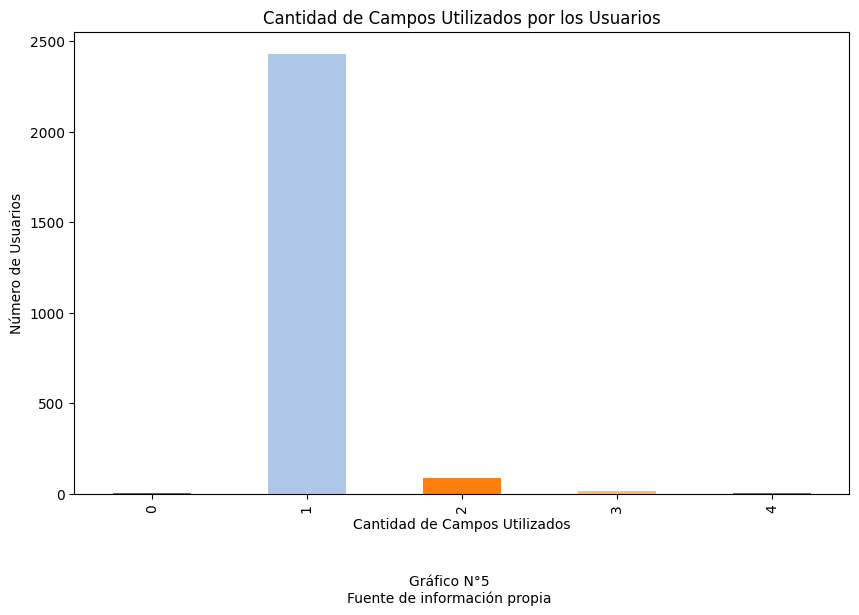

In [18]:
# Contamos la cantidad de veces que se utiliza cada cantidad de campos
cant_campos = df_filtrado['cant_campos_utilizados'].value_counts().sort_index()
print(cant_campos)

# Gráfico de barras para la cantidad de campos utilizados por los usuarios
plt.figure(figsize=(10, 6))
cant_campos.plot(kind='bar', color=plt.cm.tab20.colors)
plt.xlabel('Cantidad de Campos Utilizados')
plt.ylabel('Número de Usuarios')
plt.title('Cantidad de Campos Utilizados por los Usuarios')
plt.figtext(0.5, -0.05, 'Gráfico N°5\nFuente de información propia', ha='center', va='center')
plt.show()

##### Gráfico de barras para visualizar los campos de busqueda mas utilizados por los usuarios

kw          1808
au           255
mc-itype     206
ti           134
su            64
an            64
bc            64
su-to         30
callnum       23
l-format       5
se             3
not au         1
provider       1
in             1
Name: count, dtype: int64


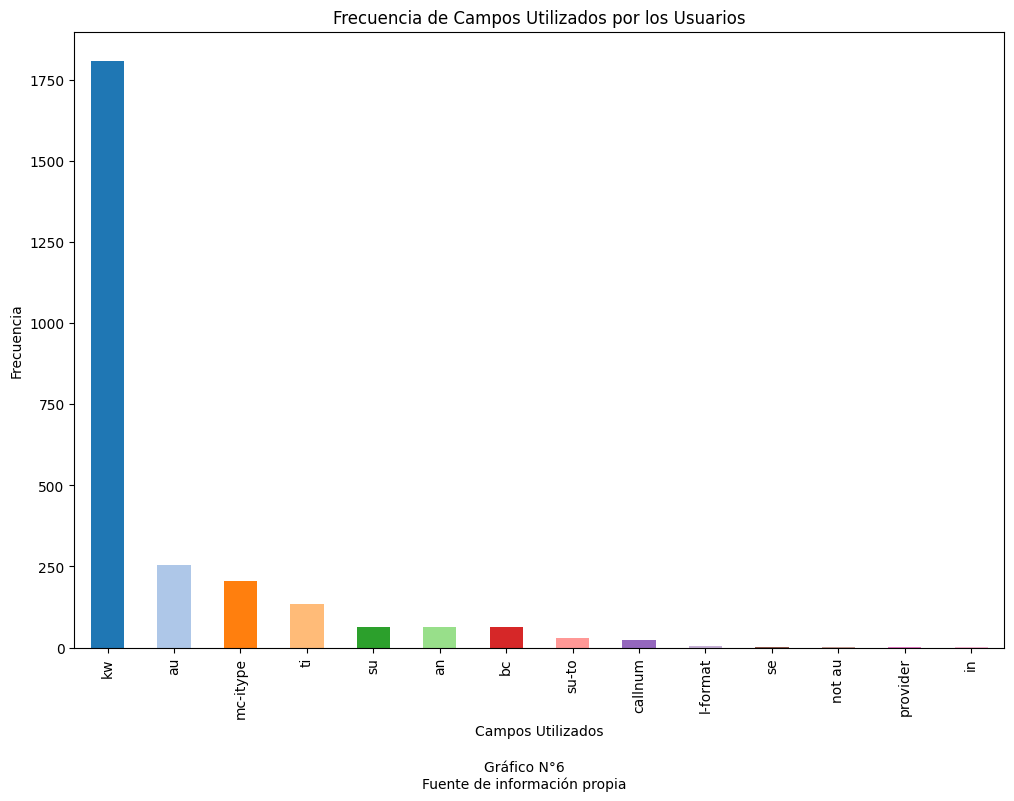

In [19]:
# Convertimos los campos a minúsculas y sumamos las frecuencias
frecuencia_campos = df_filtrado['campo_utilizado'].str.lower().str.split(', ', expand=True).stack().value_counts()
print(frecuencia_campos)

# Gráfico de las frecuencias de los campos utilizados por los usuarios
plt.figure(figsize=(12, 8))
frecuencia_campos.plot(kind='bar', color=plt.cm.tab20.colors)
plt.xlabel('Campos Utilizados')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Campos Utilizados por los Usuarios')
plt.figtext(0.5, -0.05, 'Gráfico N°6\nFuente de información propia', ha='center', va='center')
plt.show()

##### Gráfico de barras para visualizar los campos de busqueda mas utilizados por los usuarios (sin el campo 'kw')

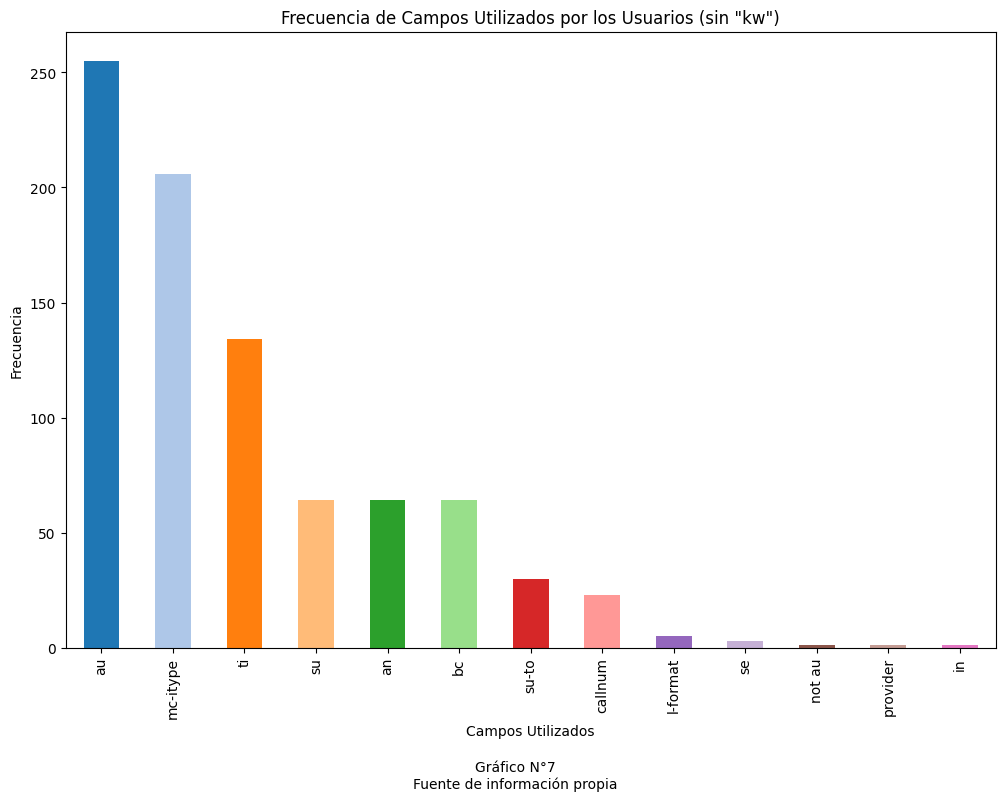

In [20]:
# Filtramos la serie para excluir el campo 'kw'
frecuencia_campos_sin_kw = frecuencia_campos.drop('kw')

# Gráfico de las frecuencias de los campos utilizados por los usuarios sin 'kw'
plt.figure(figsize=(12, 8))
frecuencia_campos_sin_kw.plot(kind='bar', color=plt.cm.tab20.colors)
plt.xlabel('Campos Utilizados')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Campos Utilizados por los Usuarios (sin "kw")')
plt.figtext(0.5, -0.05, 'Gráfico N°7\nFuente de información propia', ha='center', va='center')
plt.show()

##### Tabla de frecuencias de las combinaciones de campos que utilizaron los usuarios

In [21]:
# Filtramos las filas con más de un campo utilizado
combinaciones_campos = df_filtrado[df_filtrado['cant_campos_utilizados'] > 1]

# Contamos las combinaciones de campos utilizados
combinaciones_frecuencia = combinaciones_campos['campo_utilizado'].value_counts()
combinaciones_frecuencia_df = combinaciones_frecuencia.reset_index()
combinaciones_frecuencia_df.columns = ['Combinación de Campos', 'Frecuencia']

# Mostramos la tabla de frecuencia
print(combinaciones_frecuencia_df)

            Combinación de Campos  Frecuencia
0                    kw, mc-itype          35
1                          kw, au          12
2                       kw, su-to           9
3       mc-itype, mc-itype, su-to           4
4                       au, su-to           3
5                 mc-itype, su-to           3
6              mc-itype, mc-itype           3
7                          ti, au           3
8              mc-itype, l-format           3
9                au, su-to, su-to           3
10                   mc-itype, au           3
11                   au, mc-itype           2
12               kw, kw, mc-itype           2
13                   su, mc-itype           2
14  mc-itype, mc-itype, su-to, au           1
15     au, ti, mc-itype, mc-itype           1
16               su, kw, mc-itype           1
17                     au, ti, in           1
18                   ti, mc-itype           1
19                         su, kw           1
20                         kw, se 

### Análisis a los datos con resultado igual a cero

##### Extraemos las sintaxis de los usuarios cuando el sistema no encuentra ningun resultado

In [22]:
# Filtramos las búsquedas que tengan como resultado cero
cero_resultados = df_filtrado[df_filtrado['total'] == 0].copy()  # Usamos .copy() para asegurarnos de que sea una copia

# Vemos cuántas búsquedas tienen cero resultados
print(len(cero_resultados))

# Aplicamos la función para extraer la sintaxis de las búsquedas que tienen cero resultados
cero_resultados.loc[:, 'sintaxis'] = cero_resultados['query_desc'].apply(extraer_sintaxis)

# Reordenamos las columnas
cero_resultados = cero_resultados[['sessionid', 'query_desc', 'total', 'time', 'categorycode', 'campo_utilizado', 'sintaxis', 'cant_campos_utilizados']]

# Mostramos las primeras filas
cero_resultados.head()

317


,sessionid,query_desc,total,time,categorycode,campo_utilizado,sintaxis,cant_campos_utilizados
19,9d28dcc44487946c8370722713745f17,"kw,wrdl: handbook of moderns sensors",0,2019-02-12 12:46:49,DOCENTE,kw,handbook of moderns sensors,1
24,7762fe1145877284a417558c9d699a64,"se,wrdl: Programación",0,2019-03-01 16:21:35,BIBLIOTECA,se,Programación,1
25,7762fe1145877284a417558c9d699a64,"callnum,wrdl: Programación",0,2019-03-01 16:21:43,BIBLIOTECA,callnum,Programación,1
47,068a7bd877f76e9e6e6cb210961b11c3,"mc-itype,phr:NOTICIA",0,2019-03-13 10:31:05,TEC_MED_N,mc-itype,NOTICIA,1
50,068a7bd877f76e9e6e6cb210961b11c3,"mc-itype,phr:RL",0,2019-03-13 10:32:12,TEC_MED_N,mc-itype,RL,1


In [23]:
# Guardamos el DataFrame con los resultados son iguales a cero en un archivo CSV
cero_resultados.to_csv('1 - archivos/df_cero_resultados.csv', index=False)

In [24]:
# Aplicar la función al DataFrame 'cero_resultados' y crear una nueva columna 'error_campo'
cero_resultados['problema_detectado'] = cero_resultados.apply(verificar_error_campo, axis=1)

# Mostrar las primeras filas para verificar
cero_resultados.head()

,sessionid,query_desc,total,time,categorycode,campo_utilizado,sintaxis,cant_campos_utilizados,problema_detectado
19,9d28dcc44487946c8370722713745f17,"kw,wrdl: handbook of moderns sensors",0,2019-02-12 12:46:49,DOCENTE,kw,handbook of moderns sensors,1,
24,7762fe1145877284a417558c9d699a64,"se,wrdl: Programación",0,2019-03-01 16:21:35,BIBLIOTECA,se,Programación,1,
25,7762fe1145877284a417558c9d699a64,"callnum,wrdl: Programación",0,2019-03-01 16:21:43,BIBLIOTECA,callnum,Programación,1,campo incorrecto
47,068a7bd877f76e9e6e6cb210961b11c3,"mc-itype,phr:NOTICIA",0,2019-03-13 10:31:05,TEC_MED_N,mc-itype,NOTICIA,1,
50,068a7bd877f76e9e6e6cb210961b11c3,"mc-itype,phr:RL",0,2019-03-13 10:32:12,TEC_MED_N,mc-itype,RL,1,


In [25]:
# Vemos cual es la falla en el/los campo/s utilizado/s en las búsquedas que tienen cero resultados
cero_resultados.loc[874, 'problema_detectado'] = (cero_resultados.loc[874, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[1704, 'problema_detectado'] = (cero_resultados.loc[1704, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[1803, 'problema_detectado'] = (cero_resultados.loc[1803, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[873, 'problema_detectado'] = (cero_resultados.loc[873, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1804, 'problema_detectado'] = (cero_resultados.loc[1804, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1805, 'problema_detectado'] = (cero_resultados.loc[1805, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1806, 'problema_detectado'] = (cero_resultados.loc[1806, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1807, 'problema_detectado'] = (cero_resultados.loc[1807, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[129, 'problema_detectado'] = (cero_resultados.loc[129, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[130, 'problema_detectado'] = (cero_resultados.loc[130, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[1654, 'problema_detectado'] = (cero_resultados.loc[1654, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[131, 'problema_detectado'] = (cero_resultados.loc[131, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[450, 'problema_detectado'] = (cero_resultados.loc[450, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[449, 'problema_detectado'] = (cero_resultados.loc[449, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[446, 'problema_detectado'] = (cero_resultados.loc[446, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2108, 'problema_detectado'] = (cero_resultados.loc[2108, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[408, 'problema_detectado'] = (cero_resultados.loc[408, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[2111, 'problema_detectado'] = (cero_resultados.loc[2111, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[241, 'problema_detectado'] = (cero_resultados.loc[241, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[242, 'problema_detectado'] = (cero_resultados.loc[242, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[386, 'problema_detectado'] = (cero_resultados.loc[386, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[820, 'problema_detectado'] = (cero_resultados.loc[820, 'problema_detectado'] + '')
cero_resultados.loc[1588, 'problema_detectado'] = (cero_resultados.loc[1588, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[2189, 'problema_detectado'] = (cero_resultados.loc[2189, 'problema_detectado'] + '')
cero_resultados.loc[79, 'problema_detectado'] = (cero_resultados.loc[79, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[19, 'problema_detectado'] = (cero_resultados.loc[19, 'problema_detectado'] + '')
cero_resultados.loc[24, 'problema_detectado'] = (cero_resultados.loc[24, 'problema_detectado'] + 'campo incorrecto')
#cero_resultados.loc[47, 'problema_detectado'] = (cero_resultados.loc[47, 'problema_detectado'] + '')
#cero_resultados.loc[50, 'problema_detectado'] = (cero_resultados.loc[50, 'problema_detectado'] + '')
cero_resultados.loc[54, 'problema_detectado'] = (cero_resultados.loc[54, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[55, 'problema_detectado'] = (cero_resultados.loc[55, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[61, 'problema_detectado'] = (cero_resultados.loc[61, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[62, 'problema_detectado'] = (cero_resultados.loc[62, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[63, 'problema_detectado'] = (cero_resultados.loc[63, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[64, 'problema_detectado'] = (cero_resultados.loc[64, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[66, 'problema_detectado'] = (cero_resultados.loc[66, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[68, 'problema_detectado'] = (cero_resultados.loc[68, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[69, 'problema_detectado'] = (cero_resultados.loc[69, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[70, 'problema_detectado'] = (cero_resultados.loc[70, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[72, 'problema_detectado'] = (cero_resultados.loc[72, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[73, 'problema_detectado'] = (cero_resultados.loc[73, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[74, 'problema_detectado'] = (cero_resultados.loc[74, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[75, 'problema_detectado'] = (cero_resultados.loc[75, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[76, 'problema_detectado'] = (cero_resultados.loc[76, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[77, 'problema_detectado'] = (cero_resultados.loc[77, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[78, 'problema_detectado'] = (cero_resultados.loc[78, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[84, 'problema_detectado'] = (cero_resultados.loc[84, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[89, 'problema_detectado'] = (cero_resultados.loc[89, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[90, 'problema_detectado'] = (cero_resultados.loc[90, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[95, 'problema_detectado'] = (cero_resultados.loc[95, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[113, 'problema_detectado'] = (cero_resultados.loc[113, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[114, 'problema_detectado'] = (cero_resultados.loc[114, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[115, 'problema_detectado'] = (cero_resultados.loc[115, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[116, 'problema_detectado'] = (cero_resultados.loc[116, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[117, 'problema_detectado'] = (cero_resultados.loc[117, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[118, 'problema_detectado'] = (cero_resultados.loc[118, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[128, 'problema_detectado'] = (cero_resultados.loc[128, 'problema_detectado'] + 'campo incorrecto')
#cero_resultados.loc[138, 'problema_detectado'] = (cero_resultados.loc[138, 'problema_detectado'] + '')
cero_resultados.loc[140, 'problema_detectado'] = (cero_resultados.loc[140, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[151, 'problema_detectado'] = (cero_resultados.loc[151, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[158, 'problema_detectado'] = (cero_resultados.loc[158, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[159, 'problema_detectado'] = (cero_resultados.loc[159, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[185, 'problema_detectado'] = (cero_resultados.loc[185, 'problema_detectado'] + '')
#cero_resultados.loc[219, 'problema_detectado'] = (cero_resultados.loc[219, 'problema_detectado'] + '')
#cero_resultados.loc[220, 'problema_detectado'] = (cero_resultados.loc[220, 'problema_detectado'] + '')
#cero_resultados.loc[221, 'problema_detectado'] = (cero_resultados.loc[221, 'problema_detectado'] + '')
#cero_resultados.loc[222, 'problema_detectado'] = (cero_resultados.loc[222, 'problema_detectado'] + '')
cero_resultados.loc[243, 'problema_detectado'] = (cero_resultados.loc[243, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[271, 'problema_detectado'] = (cero_resultados.loc[271, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[274, 'problema_detectado'] = (cero_resultados.loc[274, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[278, 'problema_detectado'] = (cero_resultados.loc[278, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[293, 'problema_detectado'] = (cero_resultados.loc[293, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[294, 'problema_detectado'] = (cero_resultados.loc[294, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[298, 'problema_detectado'] = (cero_resultados.loc[298, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[323, 'problema_detectado'] = (cero_resultados.loc[323, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[327, 'problema_detectado'] = (cero_resultados.loc[327, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[339, 'problema_detectado'] = (cero_resultados.loc[339, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[346, 'problema_detectado'] = (cero_resultados.loc[346, 'problema_detectado'] + '')
cero_resultados.loc[371, 'problema_detectado'] = (cero_resultados.loc[371, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[372, 'problema_detectado'] = (cero_resultados.loc[372, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[389, 'problema_detectado'] = (cero_resultados.loc[389, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[390, 'problema_detectado'] = (cero_resultados.loc[390, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[402, 'problema_detectado'] = (cero_resultados.loc[402, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[415, 'problema_detectado'] = (cero_resultados.loc[415, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[483, 'problema_detectado'] = (cero_resultados.loc[483, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[484, 'problema_detectado'] = (cero_resultados.loc[484, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[485, 'problema_detectado'] = (cero_resultados.loc[485, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[493, 'problema_detectado'] = (cero_resultados.loc[493, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[495, 'problema_detectado'] = (cero_resultados.loc[495, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[498, 'problema_detectado'] = (cero_resultados.loc[498, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[512, 'problema_detectado'] = (cero_resultados.loc[512, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[513, 'problema_detectado'] = (cero_resultados.loc[513, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[520, 'problema_detectado'] = (cero_resultados.loc[520, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[522, 'problema_detectado'] = (cero_resultados.loc[522, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[535, 'problema_detectado'] = (cero_resultados.loc[535, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[552, 'problema_detectado'] = (cero_resultados.loc[552, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[583, 'problema_detectado'] = (cero_resultados.loc[583, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[586, 'problema_detectado'] = (cero_resultados.loc[586, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[592, 'problema_detectado'] = (cero_resultados.loc[592, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[655, 'problema_detectado'] = (cero_resultados.loc[655, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[699, 'problema_detectado'] = (cero_resultados.loc[699, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[738, 'problema_detectado'] = (cero_resultados.loc[738, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[754, 'problema_detectado'] = (cero_resultados.loc[754, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[766, 'problema_detectado'] = (cero_resultados.loc[766, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[770, 'problema_detectado'] = (cero_resultados.loc[770, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[771, 'problema_detectado'] = (cero_resultados.loc[771, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[776, 'problema_detectado'] = (cero_resultados.loc[776, 'problema_detectado'] + '')
cero_resultados.loc[793, 'problema_detectado'] = (cero_resultados.loc[793, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[802, 'problema_detectado'] = (cero_resultados.loc[802, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[809, 'problema_detectado'] = (cero_resultados.loc[809, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[810, 'problema_detectado'] = (cero_resultados.loc[810, 'problema_detectado'] + '')
cero_resultados.loc[816, 'problema_detectado'] = (cero_resultados.loc[816, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[817, 'problema_detectado'] = (cero_resultados.loc[817, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[820, 'problema_detectado'] = (cero_resultados.loc[820, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[837, 'problema_detectado'] = (cero_resultados.loc[837, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[839, 'problema_detectado'] = (cero_resultados.loc[839, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[843, 'problema_detectado'] = (cero_resultados.loc[843, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[848, 'problema_detectado'] = (cero_resultados.loc[848, 'problema_detectado'] + '')
cero_resultados.loc[852, 'problema_detectado'] = (cero_resultados.loc[852, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[865, 'problema_detectado'] = (cero_resultados.loc[865, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[871, 'problema_detectado'] = (cero_resultados.loc[871, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[872, 'problema_detectado'] = (cero_resultados.loc[872, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[885, 'problema_detectado'] = (cero_resultados.loc[885, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[891, 'problema_detectado'] = (cero_resultados.loc[891, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[892, 'problema_detectado'] = (cero_resultados.loc[892, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[894, 'problema_detectado'] = (cero_resultados.loc[894, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[895, 'problema_detectado'] = (cero_resultados.loc[895, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[897, 'problema_detectado'] = (cero_resultados.loc[897, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[938, 'problema_detectado'] = (cero_resultados.loc[938, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[939, 'problema_detectado'] = (cero_resultados.loc[939, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[944, 'problema_detectado'] = (cero_resultados.loc[944, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[946, 'problema_detectado'] = (cero_resultados.loc[946, 'problema_detectado'] + 'no hay resultados')
#cero_resultados.loc[981, 'problema_detectado'] = (cero_resultados.loc[981, 'problema_detectado'] + '')
#cero_resultados.loc[982, 'problema_detectado'] = (cero_resultados.loc[982, 'problema_detectado'] + '')
#cero_resultados.loc[983, 'problema_detectado'] = (cero_resultados.loc[983, 'problema_detectado'] + '')
#cero_resultados.loc[986, 'problema_detectado'] = (cero_resultados.loc[986, 'problema_detectado'] + '')
#cero_resultados.loc[987, 'problema_detectado'] = (cero_resultados.loc[987, 'problema_detectado'] + '')
cero_resultados.loc[1001, 'problema_detectado'] = (cero_resultados.loc[1001, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1006, 'problema_detectado'] = (cero_resultados.loc[1006, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1023, 'problema_detectado'] = (cero_resultados.loc[1023, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1024, 'problema_detectado'] = (cero_resultados.loc[1024, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1025, 'problema_detectado'] = (cero_resultados.loc[1025, 'problema_detectado'] + 'campo incorrecto')
cero_resultados.loc[1055, 'problema_detectado'] = (cero_resultados.loc[1055, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1075, 'problema_detectado'] = (cero_resultados.loc[1075, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1076, 'problema_detectado'] = (cero_resultados.loc[1076, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1086, 'problema_detectado'] = (cero_resultados.loc[1086, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1087, 'problema_detectado'] = (cero_resultados.loc[1087, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1088, 'problema_detectado'] = (cero_resultados.loc[1088, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1143, 'problema_detectado'] = (cero_resultados.loc[1143, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1145, 'problema_detectado'] = (cero_resultados.loc[1145, 'problema_detectado'] + 'no hay resultados')
#cero_resultados.loc[1146, 'problema_detectado'] = (cero_resultados.loc[1146, 'problema_detectado'] + '')
#cero_resultados.loc[1147, 'problema_detectado'] = (cero_resultados.loc[1147, 'problema_detectado'] + '')
#cero_resultados.loc[1150, 'problema_detectado'] = (cero_resultados.loc[1150, 'problema_detectado'] + '')
#cero_resultados.loc[1151, 'problema_detectado'] = (cero_resultados.loc[1151, 'problema_detectado'] + '')
cero_resultados.loc[1152, 'problema_detectado'] = (cero_resultados.loc[1152, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1153, 'problema_detectado'] = (cero_resultados.loc[1153, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1154, 'problema_detectado'] = (cero_resultados.loc[1154, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1155, 'problema_detectado'] = (cero_resultados.loc[1155, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1188, 'problema_detectado'] = (cero_resultados.loc[1188, 'problema_detectado'] + 'combinación de campos incorrecta')
cero_resultados.loc[1189, 'problema_detectado'] = (cero_resultados.loc[1189, 'problema_detectado'] + 'combinación de campos incorrecta')
#cero_resultados.loc[1207, 'problema_detectado'] = (cero_resultados.loc[1207, 'problema_detectado'] + '')
#cero_resultados.loc[1208, 'problema_detectado'] = (cero_resultados.loc[1208, 'problema_detectado'] + '')
cero_resultados.loc[1227, 'problema_detectado'] = (cero_resultados.loc[1227, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[1234, 'problema_detectado'] = (cero_resultados.loc[1234, 'problema_detectado'] + '')
cero_resultados.loc[1235, 'problema_detectado'] = (cero_resultados.loc[1235, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[1238, 'problema_detectado'] = (cero_resultados.loc[1238, 'problema_detectado'] + '')
#cero_resultados.loc[1239, 'problema_detectado'] = (cero_resultados.loc[1239, 'problema_detectado'] + '')
cero_resultados.loc[1253, 'problema_detectado'] = (cero_resultados.loc[1253, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1258, 'problema_detectado'] = (cero_resultados.loc[1258, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1270, 'problema_detectado'] = (cero_resultados.loc[1270, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1278, 'problema_detectado'] = (cero_resultados.loc[1278, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1281, 'problema_detectado'] = (cero_resultados.loc[1281, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1286, 'problema_detectado'] = (cero_resultados.loc[1286, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1292, 'problema_detectado'] = (cero_resultados.loc[1292, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1301, 'problema_detectado'] = (cero_resultados.loc[1301, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1302, 'problema_detectado'] = (cero_resultados.loc[1302, 'problema_detectado'] + 'combinacion de campos incorrecta')
cero_resultados.loc[1303, 'problema_detectado'] = (cero_resultados.loc[1303, 'problema_detectado'] + 'combinacion de campos incorrecta')
cero_resultados.loc[1312, 'problema_detectado'] = (cero_resultados.loc[1312, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1332, 'problema_detectado'] = (cero_resultados.loc[1332, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1333, 'problema_detectado'] = (cero_resultados.loc[1333, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1334, 'problema_detectado'] = (cero_resultados.loc[1334, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1343, 'problema_detectado'] = (cero_resultados.loc[1343, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1344, 'problema_detectado'] = (cero_resultados.loc[1344, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1345, 'problema_detectado'] = (cero_resultados.loc[1345, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1346, 'problema_detectado'] = (cero_resultados.loc[1346, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1361, 'problema_detectado'] = (cero_resultados.loc[1361, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1411, 'problema_detectado'] = (cero_resultados.loc[1411, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1435, 'problema_detectado'] = (cero_resultados.loc[1435, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1442, 'problema_detectado'] = (cero_resultados.loc[1442, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1448, 'problema_detectado'] = (cero_resultados.loc[1448, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1455, 'problema_detectado'] = (cero_resultados.loc[1455, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1480, 'problema_detectado'] = (cero_resultados.loc[1480, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1483, 'problema_detectado'] = (cero_resultados.loc[1483, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1506, 'problema_detectado'] = (cero_resultados.loc[1506, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1507, 'problema_detectado'] = (cero_resultados.loc[1507, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1532, 'problema_detectado'] = (cero_resultados.loc[1532, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1550, 'problema_detectado'] = (cero_resultados.loc[1550, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1556, 'problema_detectado'] = (cero_resultados.loc[1556, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[1566, 'problema_detectado'] = (cero_resultados.loc[1566, 'problema_detectado'] + '')
cero_resultados.loc[1587, 'problema_detectado'] = (cero_resultados.loc[1587, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1596, 'problema_detectado'] = (cero_resultados.loc[1596, 'problema_detectado'] + 'combinación de campos incorrecta')
cero_resultados.loc[1641, 'problema_detectado'] = (cero_resultados.loc[1641, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1656, 'problema_detectado'] = (cero_resultados.loc[1656, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1664, 'problema_detectado'] = (cero_resultados.loc[1664, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1665, 'problema_detectado'] = (cero_resultados.loc[1665, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1673, 'problema_detectado'] = (cero_resultados.loc[1673, 'problema_detectado'] + 'no hay resultados')
#cero_resultados.loc[1682, 'problema_detectado'] = (cero_resultados.loc[1682, 'problema_detectado'] + '')
#cero_resultados.loc[1684, 'problema_detectado'] = (cero_resultados.loc[1684, 'problema_detectado'] + '')
cero_resultados.loc[1724, 'problema_detectado'] = (cero_resultados.loc[1724, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1727, 'problema_detectado'] = (cero_resultados.loc[1727, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1752, 'problema_detectado'] = (cero_resultados.loc[1752, 'problema_detectado'] + 'error de tipeo')
#cero_resultados.loc[1822, 'problema_detectado'] = (cero_resultados.loc[1822, 'problema_detectado'] + '')
#cero_resultados.loc[1823, 'problema_detectado'] = (cero_resultados.loc[1823, 'problema_detectado'] + '')
cero_resultados.loc[1825, 'problema_detectado'] = (cero_resultados.loc[1825, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1826, 'problema_detectado'] = (cero_resultados.loc[1826, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1829, 'problema_detectado'] = (cero_resultados.loc[1829, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1835, 'problema_detectado'] = (cero_resultados.loc[1835, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1843, 'problema_detectado'] = (cero_resultados.loc[1843, 'problema_detectado'] + 'error de tipeo')
cero_resultados.loc[1835, 'problema_detectado'] = (cero_resultados.loc[1835, 'problema_detectado'] + 'no hay resultados')
cero_resultados.loc[1847, 'problema_detectado'] = (cero_resultados.loc[1847, 'problema_detectado'] + 'no hay resultados')



In [26]:
# # Contar la cantidad de búsquedas fallidas por cada campo utilizado
# frecuencia_campos_fallidos = cero_resultados['campo_utilizado'].value_counts()
# print(frecuencia_campos_fallidos)

# # Gráfico de las frecuencias de los campos utilizados en búsquedas fallidas
# plt.figure(figsize=(12, 8))
# frecuencia_campos_fallidos.plot(kind='bar', color=plt.cm.tab20.colors)
# plt.xlabel('Campos Utilizados')
# plt.ylabel('Frecuencia')
# plt.title('Frecuencia de Campos Utilizados en Búsquedas Fallidas')
# plt.figtext(0.5, -0.05, 'Gráfico N°8\nFuente de información propia', ha='center', va='center')
# plt.show()

# # Analizar las combinaciones de campos que resultaron en búsquedas fallidas
# combinaciones_fallidas = cero_resultados[cero_resultados['cant_campos_utilizados'] > 1]
# combinaciones_frecuencia_fallidas = combinaciones_fallidas['campo_utilizado'].value_counts()

# combinaciones_frecuencia_fallidas_df = combinaciones_frecuencia_fallidas.reset_index()
# combinaciones_frecuencia_fallidas_df.columns = ['Combinación de Campos', 'Frecuencia']

# combinaciones_frecuencia_fallidas_df['Cantidad de Campos'] = combinaciones_frecuencia_fallidas_df['Combinación de Campos'].apply(lambda x: x.count(',') + 1)

# print(combinaciones_frecuencia_fallidas_df)

# # Gráfico de las combinaciones de campos utilizados en búsquedas fallidas
# plt.figure(figsize=(12, 8))
# combinaciones_frecuencia_fallidas.plot(kind='bar', color=plt.cm.tab20.colors)
# plt.xlabel('Combinaciones de Campos Utilizados')
# plt.ylabel('Frecuencia')
# plt.title('Frecuencia de Combinaciones de Campos Utilizados en Búsquedas Fallidas')
# plt.figtext(0.5, -0.05, 'Gráfico N°9\nFuente de información propia', ha='center', va='center')
# plt.show()

# # Visualizar la distribución de las búsquedas fallidas por categoría
# categoria_fallidas = cero_resultados['categorycode'].value_counts()
# print(categoria_fallidas)

# # Gráfico de la distribución de las búsquedas fallidas por categoría
# plt.figure(figsize=(12, 8))
# categoria_fallidas.plot(kind='bar', color=plt.cm.tab20.colors)
# plt.xlabel('Categoría')
# plt.ylabel('Frecuencia')
# plt.title('Distribución de Búsquedas Fallidas por Categoría')
# plt.figtext(0.5, -0.05, 'Gráfico N°10\nFuente de información propia', ha='center', va='center')
# plt.show()